<a href="https://colab.research.google.com/github/Yatharth-Tomar/-In-Silico-approach-to-aid-drug-discovery-process-for-alzheimer-disease/blob/main/AP21110010025_YATHARTH_TOMAR_NAIVE_BAYES_THEORM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing all Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

###Loading Dataset from sklear

In [ ]:
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
irdf  = data.frame
irdf.head(15)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


###Visulaizing target column of dataset

<Axes: >

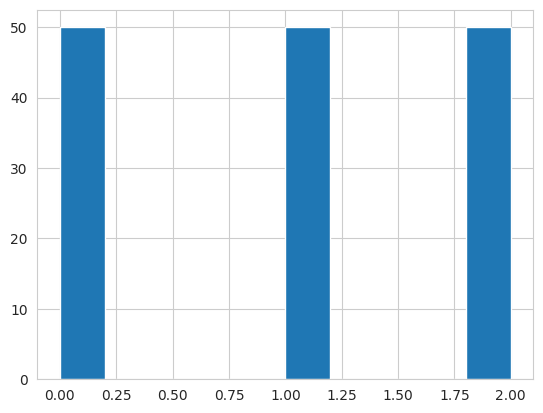

In [ ]:
irdf.target.hist()

### Removing target colmumn to build correlation matrix

In [ ]:
col_without_target = irdf.columns[irdf.columns != 'target']  # Exclude the column named 'target'
cor = irdf[col_without_target].corr()  # Compute the correlation matrix without the 'target' column
print(cor)

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


### Generating Heatmap


<Axes: >

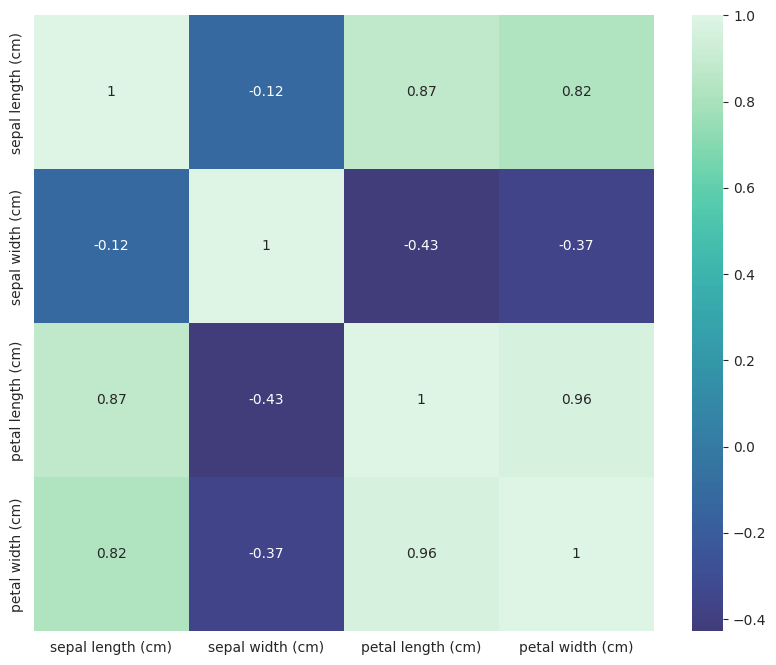

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(data=cor, annot=True,cmap="mako",center=0)

### Removing attributes with high correlation

In [ ]:
df = irdf[["sepal length (cm)", "sepal width (cm)", "target"]]
df.head()

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


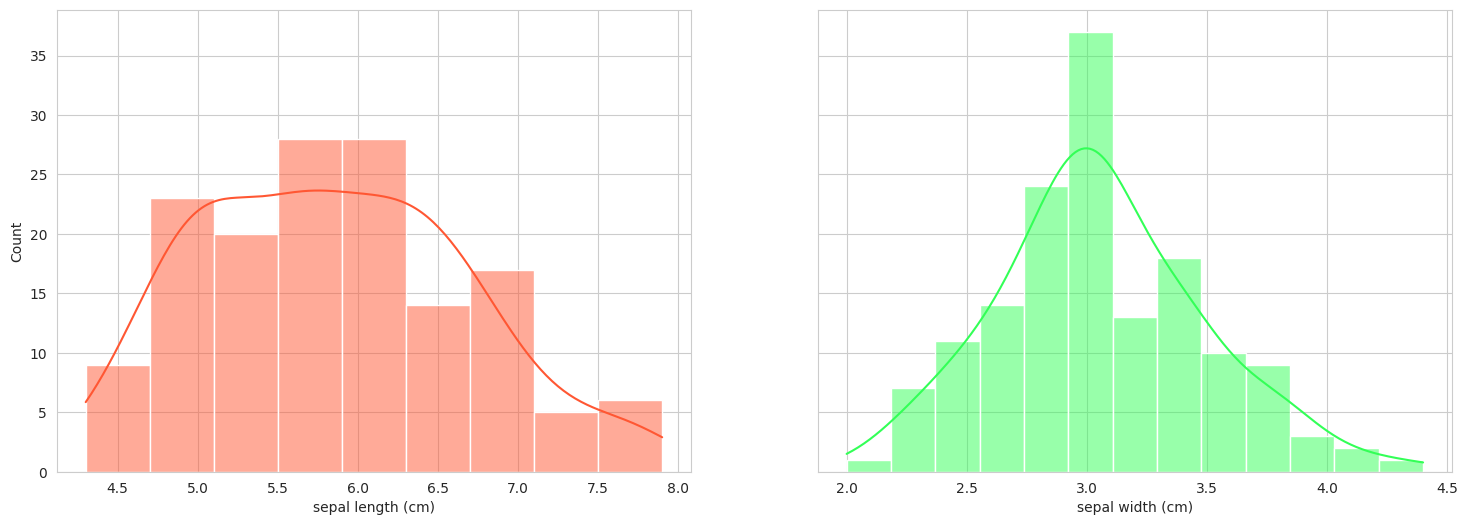

In [ ]:
custom_palette = ["#FF5733", "#33FF57", "#3366FF", "#FF33BB"]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(df, ax=axes[0], x="sepal length (cm)", kde=True, color=custom_palette[0])
sns.histplot(df, ax=axes[1], x="sepal width (cm)", kde=True, color=custom_palette[1])

plt.show()


### Calculating prior probablility

In [ ]:
def prior_prob(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        P = len(df[df[Y]==i]) / len(df)
        prior.append(P)
        print(prior)
    return prior

### Calculating likelihood probability using normal distribution formula

In [ ]:
def likelihood_prob(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    P_X_given_y = (1 / (np.sqrt(2 * np.pi * (std ** 2)))) * (np.exp(-((feat_val - mean)/ (2 * (std ** 2)))**2))

    return P_X_given_y


### calculation posterior probability

In [ ]:
def posterior(df, X, Y):
    # Extract feature names
    features = list(df.columns)[:-1]

    # Calculate prior probabilities
    prior_probs = prior_prob(df, Y)

    predicted_labels = []
    # Loop over every data sample
    for sample_idx, sample in enumerate(X):
        print(f"Calculating posterior probabilities for sample {sample_idx + 1}/{len(X)}:")

        # Calculate likelihood probabilities for each class
        class_labels = sorted(list(df[Y].unique()))
        likelihood_probs = [1] * len(class_labels)
        for j, label in enumerate(class_labels):
            print(f"  Calculating likelihood probabilities for class '{label}':")
            for i, feature in enumerate(features):
                # Multiply likelihood probabilities for all features
                likelihood_probs[j] *= likelihood_prob(df, feature, sample[i], Y, label)
                print(f"    Likelihood probability for feature '{feature}': {likelihood_probs[j]:.6f}")

        # Calculate posterior probabilities (numerator only)
        posterior_probs = [likelihood_probs[j] * prior_probs[j] for j in range(len(class_labels))]

        # Predict the class with the highest posterior probability
        predicted_label = np.argmax(posterior_probs)
        predicted_labels.append(predicted_label)

        print(f"  Posterior probabilities calculated. Predicted class: {predicted_label}")

    return np.array(predicted_labels)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=41)

# Prepare test data
X_test_data = test_data.iloc[:, :-1].values  # Features of the test set
Y_test_data = test_data.iloc[:, -1].values   # Target variable of the test set

# Predict target variable for the test set using the training data
Y_predicted = posterior(train_data, X=X_test_data, Y="target")

# Evaluate predictions
conf_matrix_result = confusion_matrix(Y_test_data, Y_predicted)  # Confusion matrix
f1_result = f1_score(Y_test_data, Y_predicted, average='weighted')  # Weighted F1 score

# Print evaluation metrics
print("Evaluation Metrics:")
print("--------------------")
print("Confusion Matrix:")
print(conf_matrix_result)
print("--------------------")
print("Weighted F1 Score:", f1_result)


[0.3416666666666667]
[0.3416666666666667, 0.325]
[0.3416666666666667, 0.325, 0.3333333333333333]
Calculating posterior probabilities for sample 1/30:
  Calculating likelihood probabilities for class '0':
    Likelihood probability for feature 'sepal length (cm)': 0.000002
    Likelihood probability for feature 'sepal width (cm)': 0.000000
  Calculating likelihood probabilities for class '1':
    Likelihood probability for feature 'sepal length (cm)': 0.717906
    Likelihood probability for feature 'sepal width (cm)': 0.000035
  Calculating likelihood probabilities for class '2':
    Likelihood probability for feature 'sepal length (cm)': 0.387321
    Likelihood probability for feature 'sepal width (cm)': 0.000001
  Posterior probabilities calculated. Predicted class: 1
Calculating posterior probabilities for sample 2/30:
  Calculating likelihood probabilities for class '0':
    Likelihood probability for feature 'sepal length (cm)': 0.000000
    Likelihood probability for feature 'sepa